# Ultralong-Range Molecule (ULRM) Electronic State Calculations

This notebook outlines the process of using the Alkali-ULRM platform for performing calculations for ultralong-range molecules (ULRMs). The workflow includes defining basis states, constructing Hamiltonian components, and diagonalizing them to obtain the electronic states. Once the electronic states are calculated, we proceed to calculate R-dependent spin admixture.

---

## Workflow
1. Initialization of the system parameters
2. Basis Construction
3. Electronic Hamiltonian Construction  
3. Diagonalization of the electronic Hamiltonian
4. Hyperfine Spin admixture
5. Rydberg state admixture

In [1]:
from src import *
from arc import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors

___
### Initialization
 
Initializing the Building Blocks for ULRM Electronic State Calculations

The initialization process involves defining the following key components:
- **Ground State Atom Species**: Specifies the properties of the ground state atom.
- **Rydberg Atom Species**: Defines the characteristics of the Rydberg atom.
- **Atom-Perturber Scattering Phases**: Includes the scattering phase shifts between the atom and perturber.
- **n_range**: The range of principal quantum numbers (`n_min`, `n_max`).
- **E_range**: The energy range (`E_min`, `E_max`).
- **`Omega`**: The total angular momentum projection.
- **`R`**: Establishes the radial grid for the calculations.

Rb_phase.3016 is the Rubidium - electron scattering phase-shift obtained from [Phys. Rev. Lett. 134, 223401](https://doi.org/10.1103/PhysRevLett.134.223401) whereas the Rb_phase.1001 is the Rubidium - electron scattering phase-shift obtained from [Phys. Rev. Lett. 123, 073003](https://doi.org/10.1103/PhysRevLett.123.073003)

In [18]:
#Load parameters for Rubidium from ARC package
#Rydberg atom
R_atom = Rubidium87()

#Ground state atom
GSatom = Rubidium87()

#Loading atom-electron phase shifts and interpolating them
phase = np.loadtxt('./data/Rb_phase.3016')
phase_shifts = phase_interpolation(phase)

#Defining the relevant n,E windows, where n0 is the manifold under investigation
n_min,n0,n_max=18,18,18 
E_min,E_max = R_atom.getEnergy(n_min+1, 2, 1.5)/eV, R_atom.getEnergy(n_max,n_max-1,n_max-0.5)/eV #eV -> a.u.

#Define radial grid R
#R[-1] should be large enough to calculate accurate Rydberg wavefunction using numerov scheme
R = np.linspace(250,2.6 * n0 * n0 ,400)

#Omega = mj + ms2 + mi is the only good quantum number for the system
Omega = 0.5

### Construction of the Rydberg and Scattering basis

This section outlines the process of constructing the Hamiltonian for ultralong-range molecules (ULRMs), including:  
1. The Rydberg basis, centered on the Rydberg core (`|alpha>`).  
2. The Scattering basis, centered on the perturber (`|beta>`).  
3. The zero energy reference: $ |18f_{7/2}> |F=1>$ state

In this example, we focus on the special case of a pure singlet p-wave ULRM, using **L=1** and **S=0**.

- To simulate a pure triplet trilobite molecule, use **L=0, S=0**.  
- To simulate a pure triplet butterfly molecule, use **L=1, S=0**.  
- For a complete system (including up to p-wave scattering), use **L=(0, 1), S=(0, 1)**.  

In [26]:
#|alpha> Rydberg basis instance; centered around the rydberg core
alpha = RydbergBasis(R_atom, n_range = (n_min,n_max), E_range = (E_min,E_max),\
                     
                        Omega  =Omega,GSatom = GSatom)
#|beta> scattering basis instance; centered around the ground state atom
beta = ScatteringBasis(Omega,GSatom,L_list=1,S_list=0)



#The zero energy reference for the dimer: ground-state atom hyperfine energy + Rydberg atom energy
A,B = GSatom.getHFSCoefficients(5,0,1/2)
E_hyperfine = GSatom.getHFSEnergyShift(0.5,1,A/10**9)
E_rydberg = R_atom.getEnergy(n0,3,3.5)/eV #eV -> a.u.

___
### Construction of the total Hamiltonian
The Hamiltonain class contains:
   - Scattering Hamiltonian (Perturber centre)
   - Rydberg Hamiltonian (Rydberg-core centre)
   - Hyperfine Hamiltonian (Rydberg-core centre)
   
which are automatically computed when an instance H is initialized.

The frame transformation matrix (`A_ab`), is evaluated only later during the diagonalization run

In [20]:
#Constructing the Hamiltonian
H = Hamiltonian(RydbergBasis=alpha, ScatteringBasis=beta, R=R, phase_shifts= phase_shifts)
print("R-independent Hamiltonian components calculated")

R-independent Hamiltonian components calculated


___
### Diagonalizing the electronic Hamiltonian
The Hamiltonian matrix is diagonalized to obtain the eigenvalues (`energy`) and eigenstates (`states`) of the system. The diagonalization considers the contributions from the Rydberg Hamiltonian, hyperfine Hamiltonian and scattering Hamiltonian which are all stored inside the instance.

Ofcourse, one only needs to just call the diagonalizate() method inside the Hamiltonian class to obtain the eigenspectra.

In [21]:
energy,states = H.diagonalize()
#Convert to GHz and shift zero energy reference, one can also work in a.u. directly
energy = GHz* (energy - E_rydberg) - E_hyperfine

(250.0, 800.0)

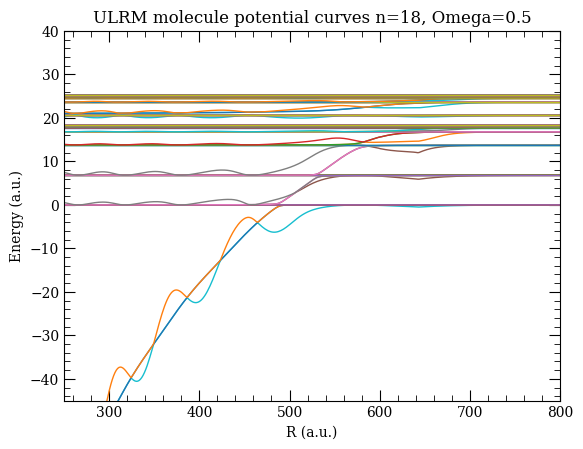

In [22]:
fig,ax = plt.subplots()
ax.plot(R,energy.transpose(),lw=1)
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title(f'ULRM molecule potential curves n={n0}, Omega={Omega}')
ax.set_ylim(-45, 40)  # Set y-axis limits
ax.set_xlim(250, 800)  # Set y-axis limits

___
### Visualization of F=1 Hyperfine State Admixture

This section calculates and visualizes the admixture of the **F=1 hyperfine state** of the Ground state atom, for each ULRM eigenstate as a function of the internuclear distance `R`.

The **F=1 projector** is defined using the `F_projector` function, and an array `F_admix` is initialized to store the admixture values for each eigenstate. The potential energies are then plotted with their colorbars signifying the F-state admixture.

Note how the adiabtic curves are hyperfine split between the non-degenerate F=1, and F=2 configurations.

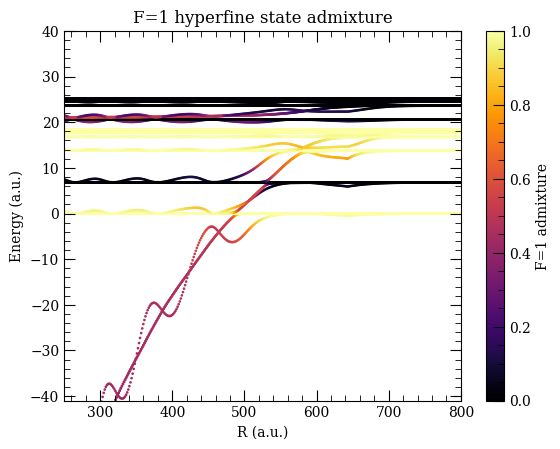

In [23]:
F_proj = F_projector(F = 1, alpha= alpha.get_basis_states())
F_admix = np.zeros_like(energy)

for j in range(energy[:,0].size):
    #Calculate S=0 admixture for each eigenstate
    F_admix[j,:] = np.einsum('ar,ab,br->r',states[:,j,:],F_proj,states[:,j,:])

fig,ax = plt.subplots()
norm = colors.Normalize(vmin=np.min(F_admix),vmax=np.max(F_admix))
for j in range(energy[:,0].size):
    cbar = ax.scatter(R, energy[j],cmap='inferno',c=F_admix[j,:],s=0.8,norm=norm)
ax.set_ylim(-41, 40)  
ax.set_xlim(250, 800)  
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title('F=1 hyperfine state admixture')
fig.colorbar(cbar,label='F=1 admixture')

___
### Visualization of $|18f_{j=7/2}>$ State Admixture

This section calculates and visualizes the admixture of the **18f Rydberg state** for each ULRM eigenstate as a function of the internuclear distance `R`. In case of a three photon association, this would be a common atomic resonance that is used in exciting the molecule.

####  Projector and Admixture Calculation
The **18f Rydberg state projector** is defined using the `Rydberg_projector` function, and an array `Ryd_admix` is initialized to store the admixture values for each eigenstate.

Notice how there are two different dissociation thresholds with maximal state admixture? These are the F=1, and F=2 configurations of the molecule with the Rydberg atom in 18f_5/2 electronic state.


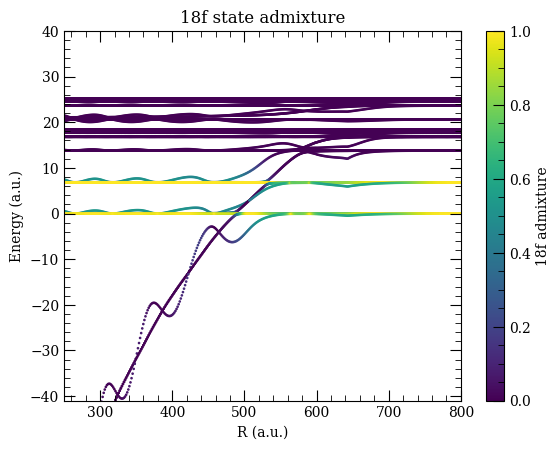

In [28]:
Ryd_proj = Rydberg_projector(n = 18, l=3, j=3.5, alpha=alpha.get_basis_states())
Ryd_admix = np.zeros_like(energy)

for j in range(energy[:,0].size):
    #Calculate the 18f state admixture for each eigenstate
    Ryd_admix[j,:] = np.einsum('ar,ab,br->r',states[:,j,:],Ryd_proj,states[:,j,:])

fig,ax = plt.subplots()
norm = colors.Normalize(vmin=np.min(Ryd_admix),vmax=np.max(Ryd_admix))
for j in range(energy[:,0].size-1,0,-1):
    cbar =ax.scatter(R, energy[j],cmap='viridis',c=Ryd_admix[j,:],s=0.8,norm=norm)
ax.set_ylim(-41, 40)  
ax.set_xlim(250, 800)  
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title('18f state admixture')
fig.colorbar(cbar,label='18f admixture')